In [101]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import DiagonalGate
from qiskit.quantum_info import Statevector
from qiskit_aer import StatevectorSimulator
import matplotlib.pyplot as plt

## Configuration

In [102]:
# Configuration parameters
NUM_QUBITS = 2  # Number of qubits
STATE_DIM = 2**NUM_QUBITS  # Dimension of state vector

print(f"Number of qubits: {NUM_QUBITS}")
print(f"State vector dimension: {STATE_DIM}")

Number of qubits: 2
State vector dimension: 4


## Create Non-Unitary Diagonal and Initial State

In [103]:
# Create a random non-unitary diagonal (real values with varying magnitudes)
np.random.seed(42)
diagonal = np.random.uniform(0.1, 1.5, STATE_DIM)

print("Diagonal elements (first 10):")
for i in range(min(10, STATE_DIM)):
    print(f"  [{i:2d}] = {diagonal[i]:+.6f}")

# Verify non-unitarity (magnitudes should vary)
magnitudes = np.abs(diagonal)
print(f"\nDiagonal magnitude check:")
print(f"  Min: {np.min(magnitudes):.6f}")
print(f"  Max: {np.max(magnitudes):.6f}")
print(f"  Mean: {np.mean(magnitudes):.6f}")
print(f"  Non-unitary: {not np.allclose(magnitudes, 1.0)}")
print(f"  All real: {np.all(np.isreal(diagonal))}")

Diagonal elements (first 10):
  [ 0] = +0.624356
  [ 1] = +1.431000
  [ 2] = +1.124792
  [ 3] = +0.938122

Diagonal magnitude check:
  Min: 0.624356
  Max: 1.431000
  Mean: 1.029567
  Non-unitary: True
  All real: True


In [104]:
# Create a random normalized initial state (real-valued)
initial_state_real = np.random.randn(STATE_DIM)
initial_state = initial_state_real / np.linalg.norm(initial_state_real)

print("Initial state (first 10 amplitudes):")
for i in range(min(10, STATE_DIM)):
    print(f"  [{i:2d}] = {initial_state[i]:+.6f}")

print(f"\nInitial state norm: {np.linalg.norm(initial_state):.10f}")
print(f"All real: {np.all(np.isreal(initial_state))}")

Initial state (first 10 amplitudes):
  [ 0] = -0.131049
  [ 1] = -0.131040
  [ 2] = +0.883841
  [ 3] = +0.429512

Initial state norm: 1.0000000000
All real: True


## Method 1: Direct Matrix Multiplication

In [105]:
# Direct multiplication
result_direct = diagonal * initial_state

print("Result from direct multiplication (first 10 amplitudes):")
for i in range(min(10, STATE_DIM)):
    print(f"  [{i:2d}] = {result_direct[i].real:+.6f} + {result_direct[i].imag:+.6f}i  |amp|={np.abs(result_direct[i]):.6f}")

print(f"\nResult norm: {np.linalg.norm(result_direct):.10f}")

Result from direct multiplication (first 10 amplitudes):
  [ 0] = -0.081821 + +0.000000i  |amp|=0.081821
  [ 1] = -0.187518 + +0.000000i  |amp|=0.187518
  [ 2] = +0.994137 + +0.000000i  |amp|=0.994137
  [ 3] = +0.402934 + +0.000000i  |amp|=0.402934

Result norm: 1.0920262414


## Method 2: LCU Decomposition

LCU (Linear Combination of Unitaries) decomposes a non-unitary operator as:
$$A = \sum_{i} \alpha_i U_i$$

For a diagonal matrix with real elements $d_j \in [0, 1]$, we decompose:
$$d_j = \frac{1}{2}[(d_j + i\sqrt{1-d_j^2}) + (d_j - i\sqrt{1-d_j^2})]$$

This is implemented using two controlled unitary diagonal gates on an ancilla qubit.

In [106]:
# Implement LCU decomposition following the collision pattern
# First, normalize diagonal to be in range [0, 1]
max_magnitude = np.max(np.abs(diagonal))
normalized_diagonal = diagonal / max_magnitude

print(f"Max magnitude: {max_magnitude:.6f}")
print(f"\nNormalized diagonal (first 10):")
for i in range(min(10, STATE_DIM)):
    print(f"  [{i:2d}] = {normalized_diagonal[i]:+.6f}")

# Create the two unitary diagonals
# unitary_1 = d + i*sqrt(1 - d^2)  for ancilla=0
# unitary_2 = d - i*sqrt(1 - d^2)  for ancilla=1
unitary_1 = normalized_diagonal + 1j * np.sqrt(1 - np.square(normalized_diagonal))
unitary_2 = normalized_diagonal - 1j * np.sqrt(1 - np.square(normalized_diagonal))

print(f"\nUnitary 1 (first 10):")
for i in range(min(10, STATE_DIM)):
    print(f"  [{i:2d}] = {unitary_1[i].real:+.6f} + {unitary_1[i].imag:+.6f}i  |val|={np.abs(unitary_1[i]):.6f}")

print(f"\nUnitary 2 (first 10):")
for i in range(min(10, STATE_DIM)):
    print(f"  [{i:2d}] = {unitary_2[i].real:+.6f} + {unitary_2[i].imag:+.6f}i  |val|={np.abs(unitary_2[i]):.6f}")

# Verify unitarity
print(f"\nUnitary 1 magnitudes - all 1.0: {np.allclose(np.abs(unitary_1), 1.0)}")
print(f"Unitary 2 magnitudes - all 1.0: {np.allclose(np.abs(unitary_2), 1.0)}")

# Create LCU circuit with ancilla qubit
num_qubits = NUM_QUBITS + 1  # system qubits + ancilla
qc_lcu = QuantumCircuit(num_qubits)

ancilla = num_qubits - 1
target_qubits = list(range(ancilla))

# Apply LCU decomposition (no initialization, we'll apply to existing state)
qc_lcu.h(ancilla)
qc_lcu.append(DiagonalGate(unitary_1).control(1, ctrl_state='0'), [ancilla] + target_qubits)
qc_lcu.append(DiagonalGate(unitary_2).control(1, ctrl_state='1'), [ancilla] + target_qubits)
qc_lcu.h(ancilla)

print(f"\nLCU Circuit depth: {qc_lcu.depth()}")
print(f"LCU Circuit operations: {qc_lcu.count_ops()}")

# Initialize state with ancilla=0 and system state
initial_state_with_ancilla = np.zeros(2 * STATE_DIM, dtype=complex)
initial_state_with_ancilla[:STATE_DIM] = initial_state  # ancilla=0 subspace

# Execute LCU circuit using StatevectorSimulator
simulator = StatevectorSimulator()
state_vector = Statevector(initial_state_with_ancilla)
result_lcu_full = state_vector.evolve(qc_lcu)
result_lcu_array_full = np.array(result_lcu_full)

print(f"\nFull LCU state dimension: {len(result_lcu_array_full)}")
print(f"Full LCU state norm: {np.linalg.norm(result_lcu_array_full):.10f}")

Max magnitude: 1.431000

Normalized diagonal (first 10):
  [ 0] = +0.436308
  [ 1] = +1.000000
  [ 2] = +0.786018
  [ 3] = +0.655571

Unitary 1 (first 10):
  [ 0] = +0.436308 + +0.899798i  |val|=1.000000
  [ 1] = +1.000000 + +0.000000i  |val|=1.000000
  [ 2] = +0.786018 + +0.618204i  |val|=1.000000
  [ 3] = +0.655571 + +0.755134i  |val|=1.000000

Unitary 2 (first 10):
  [ 0] = +0.436308 + -0.899798i  |val|=1.000000
  [ 1] = +1.000000 + +0.000000i  |val|=1.000000
  [ 2] = +0.786018 + -0.618204i  |val|=1.000000
  [ 3] = +0.655571 + -0.755134i  |val|=1.000000

Unitary 1 magnitudes - all 1.0: True
Unitary 2 magnitudes - all 1.0: True

LCU Circuit depth: 4
LCU Circuit operations: OrderedDict({'h': 2, 'cdiagonal_o0': 1, 'cdiagonal': 1})

Full LCU state dimension: 8
Full LCU state norm: 1.0000000000


## Extract LCU Result with Post-Selection

In [107]:
# Post-select on ancilla=0 to extract the result
# Qiskit uses little-endian: |q_n...q_1 q_0⟩
# Ancilla is the last qubit (highest index), so it's the most significant bit
# ancilla=0 means the first half of the state vector

# Extract ancilla=0 subspace (first half of state vector)
result_lcu_postselect = result_lcu_array_full[:STATE_DIM]

print(f"Post-selected state dimension: {len(result_lcu_postselect)}")
print(f"Post-selected state norm: {np.linalg.norm(result_lcu_postselect):.10f}")

# Renormalize the post-selected state
result_lcu_normalized = result_lcu_postselect / np.linalg.norm(result_lcu_postselect)

print(f"\nPost-selected normalized state (first 10 amplitudes):")
for i in range(min(10, STATE_DIM)):
    print(f"  [{i:2d}] = {result_lcu_normalized[i].real:+.6f} + {result_lcu_normalized[i].imag:+.6f}i  |amp|={np.abs(result_lcu_normalized[i]):.6f}")

print(f"\nNormalized state norm: {np.linalg.norm(result_lcu_normalized):.10f}")

# Scale back by max_magnitude to get the original non-unitary operation result
result_lcu_scaled = result_lcu_postselect / np.linalg.norm(result_lcu_postselect)

print(f"\nLCU result scaled by max_magnitude (first 10 amplitudes):")
for i in range(min(10, STATE_DIM)):
    print(f"  [{i:2d}] = {result_lcu_scaled[i].real:+.6f} + {result_lcu_scaled[i].imag:+.6f}i  |amp|={np.abs(result_lcu_scaled[i]):.6f}")

Post-selected state dimension: 4
Post-selected state norm: 0.7631210477

Post-selected normalized state (first 10 amplitudes):
  [ 0] = -0.074926 + -0.000000i  |amp|=0.074926
  [ 1] = -0.171716 + +0.000000i  |amp|=0.171716
  [ 2] = +0.910360 + -0.000000i  |amp|=0.910360
  [ 3] = +0.368978 + -0.000000i  |amp|=0.368978

Normalized state norm: 1.0000000000

LCU result scaled by max_magnitude (first 10 amplitudes):
  [ 0] = -0.074926 + -0.000000i  |amp|=0.074926
  [ 1] = -0.171716 + +0.000000i  |amp|=0.171716
  [ 2] = +0.910360 + -0.000000i  |amp|=0.910360
  [ 3] = +0.368978 + -0.000000i  |amp|=0.368978


## Comparison: Direct vs LCU

In [108]:
diff_lcu = result_direct - result_lcu_scaled
max_diff_lcu = np.max(np.abs(diff_lcu))
rms_diff_lcu = np.sqrt(np.mean(np.abs(diff_lcu)**2))

print("=== Direct vs LCU (post-selected and scaled) ===")
print(f"Max absolute difference: {max_diff_lcu:.3e}")
print(f"RMS difference: {rms_diff_lcu:.3e}")
print(f"Relative max error: {max_diff_lcu / np.max(np.abs(result_direct)):.3e}")
print(f"Are they equal (within 1e-10)? {max_diff_lcu < 1e-10}")

if max_diff_lcu > 1e-10:
    print("\nLargest differences (top 10):")
    sorted_indices = np.argsort(np.abs(diff_lcu))[::-1]
    for idx in sorted_indices[:10]:
        print(f"  [{idx:2d}] Direct: {result_direct[idx]:.6f}, LCU: {result_lcu_scaled[idx]:.6f}, Diff: {np.abs(diff_lcu[idx]):.3e}")

# Compare norms
print(f"\nNorm comparison:")
print(f"  Direct result norm: {np.linalg.norm(result_direct):.10f}")
print(f"  LCU result norm: {np.linalg.norm(result_lcu_scaled):.10f}")
print(f"  Norm difference: {abs(np.linalg.norm(result_direct) - np.linalg.norm(result_lcu_scaled)):.3e}")

=== Direct vs LCU (post-selected and scaled) ===
Max absolute difference: 8.378e-02
RMS difference: 4.601e-02
Relative max error: 8.427e-02
Are they equal (within 1e-10)? False

Largest differences (top 10):
  [ 2] Direct: 0.994137, LCU: 0.910360-0.000000j, Diff: 8.378e-02
  [ 3] Direct: 0.402934, LCU: 0.368978-0.000000j, Diff: 3.396e-02
  [ 1] Direct: -0.187518, LCU: -0.171716+0.000000j, Diff: 1.580e-02
  [ 0] Direct: -0.081821, LCU: -0.074926-0.000000j, Diff: 6.895e-03

Norm comparison:
  Direct result norm: 1.0920262414
  LCU result norm: 1.0000000000
  Norm difference: 9.203e-02


## Visualize Comparison

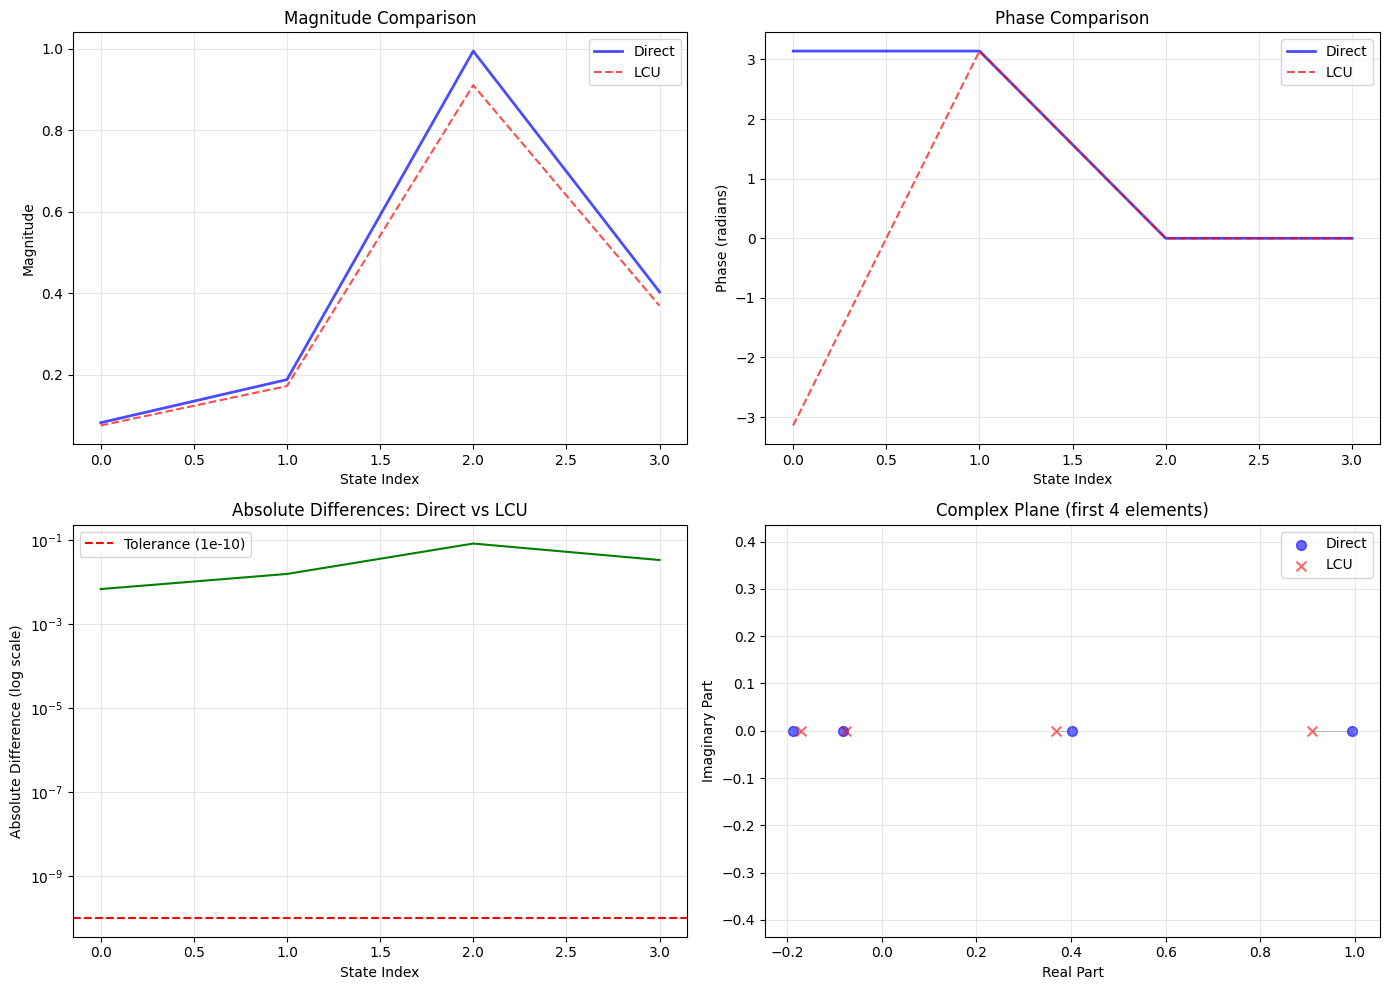


=== Summary ===
Non-unitary diagonal operator successfully implemented via LCU
Maximum difference: 8.378e-02
Methods agree within tolerance: False


In [109]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

indices = np.arange(STATE_DIM)

# Plot 1: Magnitude comparison
ax = axes[0, 0]
ax.plot(indices, np.abs(result_direct), 'b-', label='Direct', linewidth=2, alpha=0.7)
ax.plot(indices, np.abs(result_lcu_scaled), 'r--', label='LCU', linewidth=1.5, alpha=0.7)
ax.set_xlabel('State Index')
ax.set_ylabel('Magnitude')
ax.set_title('Magnitude Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Phase comparison
ax = axes[0, 1]
ax.plot(indices, np.angle(result_direct), 'b-', label='Direct', linewidth=2, alpha=0.7)
ax.plot(indices, np.angle(result_lcu_scaled), 'r--', label='LCU', linewidth=1.5, alpha=0.7)
ax.set_xlabel('State Index')
ax.set_ylabel('Phase (radians)')
ax.set_title('Phase Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Absolute differences
ax = axes[1, 0]
ax.semilogy(indices, np.abs(diff_lcu), 'g-', linewidth=1.5)
ax.axhline(y=1e-10, color='r', linestyle='--', label='Tolerance (1e-10)')
ax.set_xlabel('State Index')
ax.set_ylabel('Absolute Difference (log scale)')
ax.set_title('Absolute Differences: Direct vs LCU')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Complex plane visualization (first 50 elements)
ax = axes[1, 1]
n_plot = min(50, STATE_DIM)
ax.scatter(result_direct[:n_plot].real, result_direct[:n_plot].imag, 
          c='blue', marker='o', s=50, alpha=0.6, label='Direct')
ax.scatter(result_lcu_scaled[:n_plot].real, result_lcu_scaled[:n_plot].imag, 
          c='red', marker='x', s=50, alpha=0.6, label='LCU')
# Draw lines connecting corresponding points
for i in range(n_plot):
    ax.plot([result_direct[i].real, result_lcu_scaled[i].real],
           [result_direct[i].imag, result_lcu_scaled[i].imag],
           'k-', linewidth=0.5, alpha=0.3)
ax.set_xlabel('Real Part')
ax.set_ylabel('Imaginary Part')
ax.set_title(f'Complex Plane (first {n_plot} elements)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axis('equal')

plt.tight_layout()
plt.show()

print("\n=== Summary ===")
print(f"Non-unitary diagonal operator successfully implemented via LCU")
print(f"Maximum difference: {max_diff_lcu:.3e}")
print(f"Methods agree within tolerance: {max_diff_lcu < 1e-10}")

In [119]:
array = np.array([1, 2, 3, 4, 0.2, 0.3, 0.5, 0.11])
og_sum = np.sum(np.abs(array))
normalized_array = array / np.linalg.norm(array)

print("Original array:", array)
print("Normalized array:", normalized_array)
print("Original sum:", og_sum)
rescaled = normalized_array / np.sum(normalized_array) * og_sum
print("Rescaled array:", rescaled)

Original array: [1.   2.   3.   4.   0.2  0.3  0.5  0.11]
Normalized array: [0.18139263 0.36278527 0.5441779  0.72557053 0.03627853 0.05441779
 0.09069632 0.01995319]
Original sum: 11.11
Rescaled array: [1.   2.   3.   4.   0.2  0.3  0.5  0.11]


In [131]:
diagonal = np.array([0.5, 0.3, -0.01, 0.256, 0, 0, 0, 0])

direct = diagonal * array
direct = direct / np.linalg.norm(direct)
print(direct)

[ 0.38813653  0.46576383 -0.02328819  0.79490361  0.          0.
  0.          0.        ]


In [132]:
unitary_1 = diagonal + 1j * np.sqrt(1 - np.square(diagonal))
unitary_2 = diagonal - 1j * np.sqrt(1 - np.square(diagonal))

qc = QuantumCircuit(4)
qc.h(3)
qc.append(DiagonalGate(unitary_1).control(1, ctrl_state='0'), [3, 0, 1, 2])
qc.append(DiagonalGate(unitary_2).control(1, ctrl_state='1'), [3, 0, 1, 2])
qc.h(3)

state = Statevector(list(normalized_array) + [0, 0, 0, 0, 0, 0, 0, 0])

result = state.evolve(qc)
LCU = np.array(result)
LCU = np.real(LCU[:8]) / np.linalg.norm(LCU[:8])
print(LCU)
print(direct)
print(LCU - direct)

[ 3.88136528e-01  4.65763833e-01 -2.32881917e-02  7.94903609e-01
  2.49346763e-17  3.41211360e-17  5.77434609e-17  1.37796895e-17]
[ 0.38813653  0.46576383 -0.02328819  0.79490361  0.          0.
  0.          0.        ]
[ 5.55111512e-17 -3.88578059e-16  3.64291930e-16  2.22044605e-16
  2.49346763e-17  3.41211360e-17  5.77434609e-17  1.37796895e-17]
